# Description

- Contest Link [here](https://www.hackerearth.com/challenges/competitive/hackerearth-deep-learning-challenge-holidays/machine-learning/holiday-season-11-2c924626/)

# Contents


1.   [Load data using kaggle api](#getting-kaggle-data)
2.   [Play with data](#play-with-data)
3.   [Training code](#training-code)
    * [Create dataset](#create-dataset)
    * [Create model](#create-model)
    * [Training starts](#training-starts)
4.   [Prediction](#prediction)
5.   [Results](#details-scores-result)







# Getting Data From Kaggle via API <a name="getting-kaggle-data"></a>

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import os

os.chdir('/content/drive/My Drive/Hackerearth')
os.getcwd()

'/content/drive/My Drive/Hackerearth'

In [ ]:
! mkdir 'HolidaySeason'
% cd 'HolidaySeason'

/content/drive/My Drive/Hackerearth/HolidaySeason


In [ ]:
! kaggle datasets download -d oossiiris/hackerearth-deep-learning-challenge-holidayseason

 66% 21.0M/31.7M [00:02<00:01, 8.55MB/s]
100% 31.7M/31.7M [00:02<00:00, 14.6MB/s]


In [ ]:
! ls && pwd

hackerearth-deep-learning-challenge-holidayseason.zip
/content/drive/My Drive/Hackerearth/HolidaySeason


In [ ]:
! unzip hackerearth-deep-learning-challenge-holidayseason.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/image3052.jpg  
  inflating: dataset/train/image3055.jpg  
  inflating: dataset/train/image3056.jpg  
  inflating: dataset/train/image3057.jpg  
  inflating: dataset/train/image3059.jpg  
  inflating: dataset/train/image306.jpg  
  inflating: dataset/train/image3060.jpg  
  inflating: dataset/train/image3061.jpg  
  inflating: dataset/train/image3063.jpg  
  inflating: dataset/train/image3064.jpg  
  inflating: dataset/train/image3065.jpg  
  inflating: dataset/train/image3066.jpg  
  inflating: dataset/train/image3067.jpg  
  inflating: dataset/train/image3068.jpg  
  inflating: dataset/train/image3069.jpg  
  inflating: dataset/train/image307.jpg  
  inflating: dataset/train/image3072.jpg  
  inflating: dataset/train/image3075.jpg  
  inflating: dataset/train/image3078.jpg  
  inflating: dataset/train/image3080.jpg  
  inflating: dataset/train/image3083.jpg  
  inflating: dataset/train/image3085.jpg  
  inf

In [20]:
! pip install pretrainedmodels

     |████████████████████████████████| 61kB 5.4MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=ece1df5ff03992159e9ee4d1961fa31fe8a67c9b2f9d4dc046480709822eb072
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels


# Play Around with data <a name="play-with-data"></a>

### Explore Data

In [1]:
WORKING_DIR = '/content/drive/My Drive/Hackerearth/HolidaySeason'

import os
os.chdir(WORKING_DIR)

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd 
import numpy as np
import torch 
import torch.nn as nn

In [3]:
! ls dataset

test  train  train.csv


In [4]:
df = pd.read_csv(WORKING_DIR + '/dataset/train.csv')
df.head()

,Image,Class
0,image3476.jpg,Miscellaneous
1,image5198.jpg,Candle
2,image4183.jpg,Snowman
3,image1806.jpg,Miscellaneous
4,image7831.jpg,Miscellaneous


In [5]:
# Unequal distribution of training images across classes
# Use stratified split across the class while training

df.groupby('Class').count()

,Image
Class,
Airplane,535
Candle,593
Christmas_Tree,1539
Jacket,640
Miscellaneous,2801
Snowman,361


In [6]:
# number of unique Classes

len(df['Class'].unique())

6

In [7]:
# Manual One-hot-encoding xD
labels = list(df['Class'].unique())
indexToLabel = labels
labelToIndex = dict((label, index) for index, label in enumerate(labels))

### Split the data <a name="create-dataset"></a>

In [8]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['Class'])

In [9]:
len(train_df)/ (len(train_df) + len(val_df)) # 80% for train

0.7999690833204514

In [10]:
train_df.reset_index(inplace=True)
train_df = train_df[['Image', 'Class']]

train_df.head()

,Image,Class
0,image3130.jpg,Miscellaneous
1,image3775.jpg,Christmas_Tree
2,image2104.jpg,Miscellaneous
3,image1046.jpg,Miscellaneous
4,image2787.jpg,Airplane


In [11]:
val_df.reset_index(inplace=True)
val_df = val_df[['Image', 'Class']]

val_df.head()

,Image,Class
0,image4877.jpg,Jacket
1,image7876.jpg,Miscellaneous
2,image3291.jpg,Snowman
3,image2899.jpg,Candle
4,image6638.jpg,Candle


### Training Starts <a name="training-code"></a>

In [12]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2
from PIL import Image

In [13]:
class ImgData(Dataset):
  def __init__(self, csv_df, root_dir, transform=None):
    self.csv = csv_df
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.csv)

  def __getitem__(self, idx):
    img = cv2.imread(self.root_dir + self.csv['Image'][idx])
    label = labelToIndex[self.csv['Class'][idx]]

    if self.transform:
      img = self.transform(img)

    return {'img': img, 'label': label, 'id': self.csv['Image'][idx]}

In [14]:
# normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
#                                  std=[0.5, 0.5, 0.5])
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225])

In [15]:
# Average image width and height is around 128, 128. 
# to make our dataset fit to the pretrained model, we are resizing each
# image to (299, 299)

# Most images have snake at the center :)

# Data  augumentation to make our model more robust.
data_transform = {
    "train": transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomGrayscale(p=0.1),
        transforms.RandomRotation(25),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    "val": transforms.Compose([
          transforms.ToPILImage(),
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
          normalize
    ])
    }

In [16]:
holidayTrainDataset = ImgData(train_df, WORKING_DIR + '/dataset/train/', data_transform['train'])
holidayValDataset = ImgData(val_df, WORKING_DIR + '/dataset/train/', data_transform['val'])

In [17]:
holidayDataloader = {'train': DataLoader(holidayTrainDataset, batch_size=64, num_workers=4, shuffle=True),
                   'val': DataLoader(holidayValDataset, batch_size=64, num_workers=4, shuffle=True)}

### Create Model <a name='create-model'></a>

- Transfer Learning

In [21]:
from torchvision.models import resnet50, resnet101, densenet161
from torch.nn import functional as F
import torch.optim as optim

from InceptionResnet_v2 import inceptionresnetv2
from pretrainedmodels import senet154

In [ ]:
# ! pip install git+https://github.com/wielandbrendel/bag-of-local-features-models.git

In [22]:
# model = resnet50(pretrained=True)
# model = inceptionresnetv2()
# import bagnets.pytorchnet
# model = bagnets.pytorchnet.bagnet17(pretrained=True)
# model = densenet161(pretrained=True)
model = senet154()

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/senet154-c7b49a05.pth" to /root/.cache/torch/hub/checkpoints/senet154-c7b49a05.pth


In [23]:
for param in model.parameters():
  param.requires_grad = False

In [24]:
num_class = len(indexToLabel)

In [28]:
# model.classifier = nn.Sequential(
#     nn.Linear(2208, 700),
#     nn.BatchNorm1d(num_features=700),
#     nn.ReLU(inplace=True),
#     nn.Linear(700, num_class)
# )
model.last_linear = nn.Sequential(
    nn.Linear(2048, 700),
    nn.BatchNorm1d(num_features=700),
    nn.ReLU(inplace=True),
    nn.Linear(700, num_class)
)

In [29]:
model

SENet(
  (layer0): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (layer1): Sequential(
    (0): SEBottleneck(
      (conv1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): C

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
device

device(type='cuda', index=0)

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.last_linear.parameters(), lr=0.01)
# optimizer = optim.Adam(model.classifier.parameters(), lr=0.01)

In [33]:
# from torch.optim.lr_scheduler import StepLR  
# scheduler = StepLR(optimizer, step_size=5, gamma=0.3, verbose=True)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, patience=3, threshold=0.01, verbose=True)

### Training Starts <a name='training-starts'></a>

In [35]:
from tqdm.autonotebook import tqdm
from copy import deepcopy
from sklearn.metrics import f1_score

n_epoch = 40
model.train()
epoch_losses = {
    'val': [],
    'train': []
}

epoch_accs = {
    'val': [],
    'train': []
}

best_acc = 0.0
best_model = deepcopy(model.state_dict())


for epoch in range(n_epoch):
  epoch_loss = 0.0
  epoch_acc = 0.0

  outputs = []
  targets = []
  print('=' * 25, '[Epoch:', epoch+1, '/', n_epoch, ']', '=' * 25)

#   scheduler.step()

  for phase in ['train', 'val']:
    if phase == 'train':
      model.train()
    else:
      model.eval()

    running_loss = 0.0
    running_correct = 0.0

    for data in tqdm(holidayDataloader[phase], position=0, leave=False):
      img, label = data['img'], data['label']
      img = img.to(device)
      label = torch.tensor(label).to(device)
    #   print('shapes: ', img.shape, label.shape)

      optimizer.zero_grad()

      with torch.set_grad_enabled(phase=='train'):
        outs = model(img)
        preds = torch.argmax(outs, 1)
        loss = criterion(outs, label)

        if phase == 'train':
          loss.backward()
          optimizer.step()
          
        running_loss += loss.item() * img.size()[0]
        running_correct += torch.sum(preds == label.data)

        if phase == 'val':
          outputs.append(preds.cpu().detach().numpy())
          targets.append(label.cpu().detach().numpy())
    
    epoch_loss = running_loss / len(holidayDataloader[phase])
    epoch_acc = running_correct.double() / len(holidayDataloader[phase])

    print(f'[{phase}] => Acc: {epoch_acc :.2f}  Loss: {epoch_loss :.2f}')
    if phase == 'val':
      outputs = np.concatenate(outputs)
      targets = np.concatenate(targets)
      print(f"[val] => f1-score {f1_score(outputs, targets, average='weighted') :.2f}")

    epoch_losses[phase].append(epoch_loss)
    epoch_accs[phase].append(epoch_acc)

    if phase == 'val' and epoch_acc > best_acc:
      best_acc = epoch_acc
      # best_model = deepcopy(model.state_dict())
    elif phase == 'train':
      scheduler.step(epoch_loss)





========================= [Epoch: 1 / 40 ] =========================


[train] => Acc: 42.64  Loss: 60.54


[val] => Acc: 45.90  Loss: 45.09
[val] => f1-score 0.77
========================= [Epoch: 2 / 40 ] =========================


[train] => Acc: 47.14  Loss: 44.69


[val] => Acc: 46.29  Loss: 41.23
[val] => f1-score 0.76
========================= [Epoch: 3 / 40 ] =========================


[train] => Acc: 48.52  Loss: 40.77


[val] => Acc: 45.29  Loss: 46.81
[val] => f1-score 0.75
========================= [Epoch: 4 / 40 ] =========================


[train] => Acc: 50.20  Loss: 37.42


[val] => Acc: 44.29  Loss: 46.12
[val] => f1-score 0.73
========================= [Epoch: 5 / 40 ] =========================


[train] => Acc: 50.74  Loss: 34.63


[val] => Acc: 46.10  Loss: 43.91
[val] => f1-score 0.76
========================= [Epoch: 6 / 40 ] =========================


[train] => Acc: 51.51  Loss: 33.06


[val] => Acc: 44.86  Loss: 48.38
[val] => f1-score 0.73
========================= [Epoch: 7 / 40 ] =========================


[train] => Acc: 51.70  Loss: 33.66


[val] => Acc: 46.52  Loss: 41.36
[val] => f1-score 0.76
========================= [Epoch: 8 / 40 ] =========================


[train] => Acc: 51.91  Loss: 31.59


[val] => Acc: 46.76  Loss: 40.80
[val] => f1-score 0.76
========================= [Epoch: 9 / 40 ] =========================


[train] => Acc: 52.44  Loss: 30.30


[val] => Acc: 46.38  Loss: 43.75
[val] => f1-score 0.75
========================= [Epoch: 10 / 40 ] =========================


[train] => Acc: 52.23  Loss: 30.69


[val] => Acc: 48.29  Loss: 39.61
[val] => f1-score 0.79
========================= [Epoch: 11 / 40 ] =========================


[train] => Acc: 52.85  Loss: 28.76


[val] => Acc: 47.10  Loss: 41.06
[val] => f1-score 0.76
========================= [Epoch: 12 / 40 ] =========================


[train] => Acc: 52.46  Loss: 29.25


[val] => Acc: 48.38  Loss: 38.09
[val] => f1-score 0.79
========================= [Epoch: 13 / 40 ] =========================


[train] => Acc: 53.16  Loss: 27.23


[val] => Acc: 47.62  Loss: 38.77
[val] => f1-score 0.77
========================= [Epoch: 14 / 40 ] =========================


[train] => Acc: 53.70  Loss: 26.79


[val] => Acc: 44.62  Loss: 47.93
[val] => f1-score 0.71
========================= [Epoch: 15 / 40 ] =========================


[train] => Acc: 53.51  Loss: 27.36


[val] => Acc: 49.10  Loss: 37.66
[val] => f1-score 0.80
========================= [Epoch: 16 / 40 ] =========================


[train] => Acc: 53.98  Loss: 26.59


[val] => Acc: 45.90  Loss: 46.44
[val] => f1-score 0.74
========================= [Epoch: 17 / 40 ] =========================


[train] => Acc: 53.52  Loss: 27.19


[val] => Acc: 47.76  Loss: 38.47
[val] => f1-score 0.78
========================= [Epoch: 18 / 40 ] =========================


[train] => Acc: 54.37  Loss: 25.42


[val] => Acc: 47.10  Loss: 41.60
[val] => f1-score 0.76
========================= [Epoch: 19 / 40 ] =========================


[train] => Acc: 54.57  Loss: 24.89


[val] => Acc: 48.90  Loss: 38.91
[val] => f1-score 0.80
========================= [Epoch: 20 / 40 ] =========================


[train] => Acc: 54.41  Loss: 24.98


[val] => Acc: 49.86  Loss: 36.37
[val] => f1-score 0.81
========================= [Epoch: 21 / 40 ] =========================


[train] => Acc: 54.75  Loss: 24.33


[val] => Acc: 49.14  Loss: 39.85
[val] => f1-score 0.80
========================= [Epoch: 22 / 40 ] =========================


[train] => Acc: 54.77  Loss: 23.53


[val] => Acc: 48.76  Loss: 38.62
[val] => f1-score 0.79
========================= [Epoch: 23 / 40 ] =========================


[train] => Acc: 54.90  Loss: 23.81


[val] => Acc: 48.71  Loss: 44.24
[val] => f1-score 0.80
========================= [Epoch: 24 / 40 ] =========================


[train] => Acc: 54.85  Loss: 23.66


[val] => Acc: 49.00  Loss: 37.90
[val] => f1-score 0.80
========================= [Epoch: 25 / 40 ] =========================


[train] => Acc: 56.06  Loss: 22.12


[val] => Acc: 50.48  Loss: 35.86
[val] => f1-score 0.82
========================= [Epoch: 26 / 40 ] =========================


[train] => Acc: 54.93  Loss: 24.01


[val] => Acc: 50.10  Loss: 33.82
[val] => f1-score 0.81
========================= [Epoch: 27 / 40 ] =========================


[train] => Acc: 55.06  Loss: 23.30


[val] => Acc: 48.48  Loss: 37.44
[val] => f1-score 0.79
========================= [Epoch: 28 / 40 ] =========================


[train] => Acc: 55.38  Loss: 22.33


[val] => Acc: 50.10  Loss: 33.82
[val] => f1-score 0.81
========================= [Epoch: 29 / 40 ] =========================


[train] => Acc: 56.12  Loss: 20.67


[val] => Acc: 51.43  Loss: 32.12
[val] => f1-score 0.84
========================= [Epoch: 30 / 40 ] =========================


[train] => Acc: 55.78  Loss: 21.68


[val] => Acc: 46.62  Loss: 43.07
[val] => f1-score 0.75
========================= [Epoch: 31 / 40 ] =========================


[train] => Acc: 55.65  Loss: 22.63


[val] => Acc: 49.76  Loss: 35.25
[val] => f1-score 0.81
========================= [Epoch: 32 / 40 ] =========================


[train] => Acc: 56.25  Loss: 19.95


[val] => Acc: 49.19  Loss: 38.73
[val] => f1-score 0.80
========================= [Epoch: 33 / 40 ] =========================


[train] => Acc: 55.93  Loss: 21.85


[val] => Acc: 49.81  Loss: 34.75
[val] => f1-score 0.81
========================= [Epoch: 34 / 40 ] =========================


[train] => Acc: 55.84  Loss: 21.21


[val] => Acc: 49.71  Loss: 35.47
[val] => f1-score 0.81
========================= [Epoch: 35 / 40 ] =========================


[train] => Acc: 56.01  Loss: 21.05


[val] => Acc: 48.95  Loss: 37.41
[val] => f1-score 0.80
========================= [Epoch: 36 / 40 ] =========================


[train] => Acc: 56.07  Loss: 21.54
Epoch    36: reducing learning rate of group 0 to 1.0000e-03.


[val] => Acc: 49.43  Loss: 36.70
[val] => f1-score 0.80
========================= [Epoch: 37 / 40 ] =========================


[train] => Acc: 56.84  Loss: 19.06


[val] => Acc: 49.67  Loss: 36.16
[val] => f1-score 0.81
========================= [Epoch: 38 / 40 ] =========================


[train] => Acc: 57.27  Loss: 18.45


[val] => Acc: 50.00  Loss: 34.51
[val] => f1-score 0.81
========================= [Epoch: 39 / 40 ] =========================


[train] => Acc: 57.33  Loss: 17.98


[val] => Acc: 50.19  Loss: 35.11
[val] => f1-score 0.82
========================= [Epoch: 40 / 40 ] =========================


[train] => Acc: 57.90  Loss: 16.55


[val] => Acc: 50.19  Loss: 35.49
[val] => f1-score 0.82


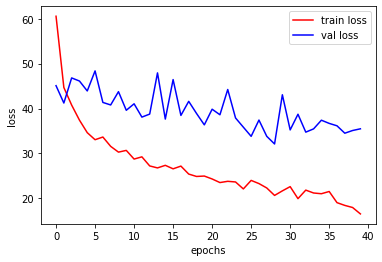

In [36]:
import matplotlib.pyplot as plt

plt.plot(epoch_losses['train'], color='red', label='train loss')
plt.plot(epoch_losses['val'], color='blue', label='val loss')
plt.legend(loc="upper right")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

# Predict <a name='prediction'></a>

In [37]:
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

In [38]:
! ls dataset/test/

image100.jpg   image2815.jpg  image4568.jpg  image6304.jpg  image8125.jpg
image1013.jpg  image2817.jpg  image456.jpg   image6307.jpg  image8129.jpg
image1014.jpg  image2819.jpg  image4572.jpg  image630.jpg   image8130.jpg
image1018.jpg  image281.jpg   image4575.jpg  image6314.jpg  image8132.jpg
image1019.jpg  image2821.jpg  image4577.jpg  image6317.jpg  image8134.jpg
image1021.jpg  image2827.jpg  image457.jpg   image6319.jpg  image8137.jpg
image1023.jpg  image2830.jpg  image4580.jpg  image6320.jpg  image8142.jpg
image1024.jpg  image2831.jpg  image4583.jpg  image6321.jpg  image8147.jpg
image1029.jpg  image2833.jpg  image4584.jpg  image6329.jpg  image8149.jpg
image1030.jpg  image2836.jpg  image4586.jpg  image632.jpg   image8151.jpg
image1031.jpg  image2840.jpg  image4589.jpg  image6331.jpg  image8159.jpg
image1032.jpg  image2841.jpg  image4593.jpg  image6332.jpg  image8168.jpg
image1034.jpg  image2842.jpg  image4594.jpg  image6336.jpg  image816.jpg
image1035.jpg  image2843.jpg  image4596

In [39]:
# test_csv = pd.read_csv(WORKING_DIR + '/dataset/test.csv')
fileNames = os.listdir(WORKING_DIR + '/dataset/test/')
fileNames = [[name, 'Candle'] for index, name in enumerate(fileNames)]
test_csv = pd.DataFrame(fileNames, columns=['Image', 'Class'])

holidayTestDataset = ImgData(test_csv, WORKING_DIR + '/dataset/test/', test_transform)
holidayTestDataloader = DataLoader(holidayTestDataset, batch_size=32) 

preds = pd.DataFrame(columns=['Image', 'Class'])

In [40]:
test_csv.head()

,Image,Class
0,image6069.jpg,Candle
1,image4596.jpg,Candle
2,image406.jpg,Candle
3,image5086.jpg,Candle
4,image6185.jpg,Candle


In [41]:
model.eval()
from tqdm import tqdm

for index, data in enumerate(tqdm(holidayTestDataloader, position=0, leave=True)):
  img, label, id = data['img'], data['label'], data['id']
  img = img.to(device)
  outs = model(img)
  cls = torch.argmax(outs, dim=1)

  for img_id, img_cls in zip(data['id'], cls):
    preds = preds.append({'Image': img_id, 'Class': indexToLabel[img_cls]}, ignore_index=True)

100%|██████████| 110/110 [44:37<00:00, 24.34s/it]


In [42]:
preds.head()

,Image,Class
0,image6069.jpg,Christmas_Tree
1,image4596.jpg,Miscellaneous
2,image406.jpg,Miscellaneous
3,image5086.jpg,Christmas_Tree
4,image6185.jpg,Christmas_Tree


In [43]:
set(preds['Image']) == set(test_csv['Image']) 

True

In [44]:
len(preds), len(test_csv)

(3489, 3489)

In [45]:
preds.to_csv(WORKING_DIR + '/pred.csv')

In [46]:
torch.save(model.state_dict(), 'inception_resnet_v2_weights.pth')

In [49]:
"""
Details: Pretrained senet154 with 40 epochs
Score: 79.15325
path: https://github.com/harshraj22/DeepLearning/blob/main/submissions/HackerEarth: [Holiday Season]/Holiday_Season.ipynb
"""

'\nDetails: Pretrained senet154 with 40 epochs\nScore: 79.15325\npath: https://github.com/harshraj22/DeepLearning/blob/main/submissions/HackerEarth: [Holiday Season]/Holiday_Season.ipynb\n'

# Rough Work

In [48]:
file = WORKING_DIR + '/dataset/train/' + 'image3492.jpg'

In [ ]:
for data in holidayDataloader['train']:
  print(data)
  break

{'img': tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1

In [ ]:
len(df)

6469

In [ ]:
len(os.listdir(WORKING_DIR + '/dataset/train/'))

6469

In [ ]:
# ! cp '/content/drive/MyDrive/Hackerearth/InceptionResnet_v2.py'  ./